# Introduction to generative network models

#### Your task

##### Simulation

* Implement the Barabási-Albert preferential attachment model, and generate a random network with this model. Make sure the network is undirected and contains no self-loops. Pick $10000 < n < 100000$ (be kind to your hardware), and $n_0 < 6$.
* Determine and plot the degree distribution of your generated network. Use a log-log scale. Read section <http://networksciencebook.com/chapter/4#advanced-b> of the Network Science book on how to properly do this - I was lazy on some of the slides! :)
* This model should lead to a power-law degree distribution. Estimate the power-law scaling coefficient $\alpha$ using
  * Linear regression of $y=\log P(k)$ on $y=\log k$,
  * The approximation by Clauset et al. (2007), see Equation (3.7) in their paper.
  * The maximum likelihood estimation approach by Clauset et al. (2007), see the Python toolbox `powerlaw` <https://pypi.org/project/powerlaw/>.
  * Note that you'll have to think about what to do with $k_{min}$ ($x_{min}$ in the paper).
* How do the different approaches fare, compared to the theoretical result of $\alpha=3.0$?
* Now implement another network null model (see slides, reading material, or the `networkx` documentation for examples) that should _not_ result in a power-law degree distribution, and use the procedures above to check whether it perhaps _is_ a power-law. Does the estimation procedure correctly find evidence for the negative?

##### Empirical

* Download two of the collaboration networks (other than the astrophysics network which was used in the lecture slides) from <http://snap.stanford.edu/data/index.html>.
* (Properly) visualize the degree distributions of these networks, using again the techniques from <http://networksciencebook.com/chapter/4#advanced-b>. Use the `powerlaw` toolbox again to compare the model fit of a power-law with other potential distributions, such as the log-normal. Is a power-law a reasonable claim for these networks?

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import powerlaw as pwr
import numpy as np
import matplotlib.pyplot as plt
import math
import random

## Simulation

### Barbési-Albert Model

In [2]:
# Parameters
m_0 = 5
m = 4
n = 12000

# initialize fully connected graph
G = nx.complete_graph(m_0)

# add 12000 nodes
for i in range(n):
    #calculate updatetd degrees
    degrees = [val for _,val in G.degree]
    probabilities = np.array(degrees) / sum(degrees)
    indeces = np.arange(m_0+i)
    # take m sample nodes and connect them to current node
    sample = np.random.choice(indeces, m, p = probabilities, replace=False)
    for node in sample:
        G.add_edge(m_0+i, node)

# just to save some memory
del degrees
del probabilities
del indeces


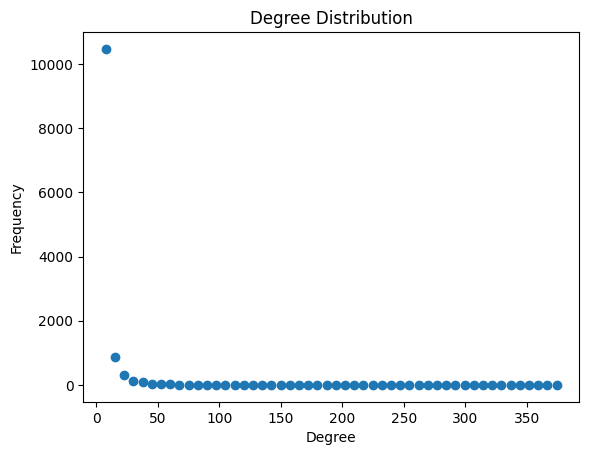

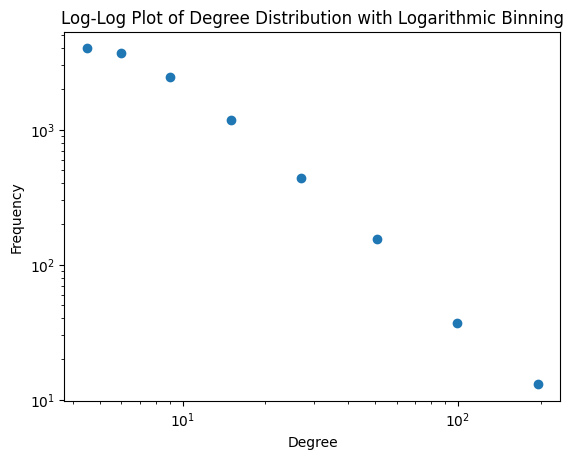

In [3]:
degrees = np.array([val for _,val in G.degree])

# ordinary plot
counts, edges = np.histogram(degrees, bins=50)
bin_centers = 0.5 * (edges[1:] + edges[:-1]) 
plt.plot(bin_centers, counts, 'o')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.show()

# logarithmic binning (starting with 4 as this is the lowest possible degree)
bins = [m]
for i in range(8):
    new_bin = bins[-1] + 2**(i)
    bins.append(new_bin)
bins = np.array(bins)
counts, edges = np.histogram(degrees, bins=bins)
bin_centers = 0.5 * (edges[1:] + edges[:-1]) 

# log-log plot
plt.plot(bin_centers, counts, 'o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Log-Log Plot of Degree Distribution with Logarithmic Binning')
plt.show()


The Log-Log Plot shows a fairly linear relationship, hinting at powerlaw distribution being a good fit. The first two bins don't fit the powerlaw very well, so x_min should be 7.

In [4]:
x_min = 7

# Linear Regression
from sklearn.linear_model import LinearRegression
from collections import Counter

# transform degrees into probabilities
c = Counter(degrees)
Y = np.array([math.log(c[key]) for key in c if c[key] >= x_min]).reshape(-1, 1)
X = np.array([math.log(key) for key in c if c[key] >= x_min]).reshape(-1, 1)

# fit data with regression
reg = LinearRegression().fit(X, Y)
print('Alpha fit through linear regression:', -reg.coef_[0][0])

# Clauset et al. (2007)
log_values = [math.log(d/(x_min-0.5)) for d in degrees if d >= x_min]
alpha = 1 + len(log_values) / sum(log_values)
print('Alpha fit through method from Clauset et al. (2007):', alpha)

# Powerlaw package
fit_generated = pwr.Fit(degrees, x_min=x_min, discrete=True, verbose=False)
print('Alpha fit through Powerlaw package:', fit_generated.power_law.alpha)

Alpha fit through linear regression: 2.699407811582085
Alpha fit through method from Clauset et al. (2007): 2.8002748996292386
Alpha fit through Powerlaw package: 2.824589092884996


All three methods achieve a reasonable approximation of the theoretical $\alpha = 3$. The Powerlaw package does the best, followed by the method from Clauset et al (2007) and finally linear regression. All of them tend to estimate $\alpha$ smaller than the theoretical value.

### Erdős–Rényi Model

In [5]:
# chance of connecting two nodes set to 1%
p = 0.01
G = nx.empty_graph(n)

for i in range(n):
    for j in range(n-i-1):
        roll = random.uniform(0, 1)
        if roll <= p:
            G.add_edge(i, j+i+1)

degrees = np.array([val for _,val in G.degree])
print('Minimum Degree:', min(degrees), 'Maximum Degree:', max(degrees))

Minimum Degree: 78 Maximum Degree: 160


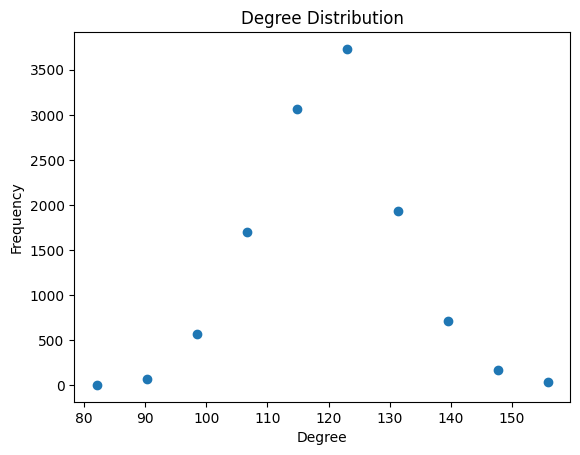

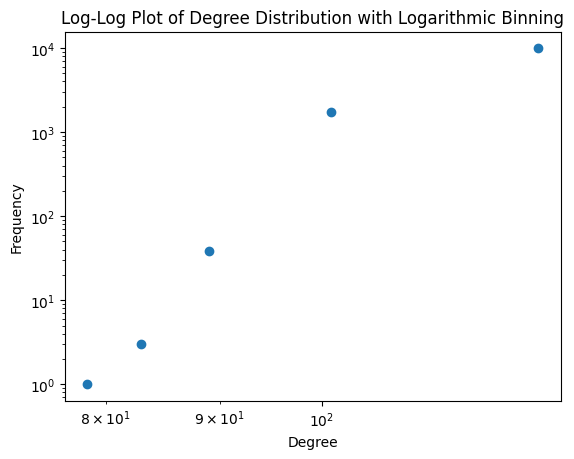

In [6]:
counts, edges = np.histogram(degrees)
bin_centers = 0.5 * (edges[1:] + edges[:-1]) 
plt.plot(bin_centers, counts, 'o')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.show()

# logarithmic binning
bins = [min(degrees)]
for i in range(6):
    new_bin = bins[-1] + 2**(i)
    bins.append(new_bin)
bins = np.array(bins)
counts, edges = np.histogram(degrees, bins=bins)
bin_centers = 0.5 * (edges[1:] + edges[:-1]) 

# plotting the data
plt.plot(bin_centers, counts, 'o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Log-Log Plot of Degree Distribution with Logarithmic Binning')
plt.show()

We can see that the degrees are not powerlaw distributed but instead normally distributed, as to be expexted from a Erdös-Réyni model. Since there is no powerlaw distribution, it is not possible to choose a reasonable x_min from inspection.

In [7]:
# Linear Regression
from sklearn.linear_model import LinearRegression
from collections import Counter

# transform degrees into probabilities
c = Counter(degrees)
Y = np.array([math.log(c[key]) for key in c]).reshape(-1, 1)
X = np.array([math.log(key) for key in c]).reshape(-1, 1)

# fit data with regression
reg = LinearRegression().fit(X, Y)
print('Alpha fit through linear regression:', -reg.coef_[0][0])

# Clauset et al. (2007)
log_values = [math.log(d/(x_min-0.5)) for d in degrees]
alpha = 1 + len(log_values) / sum(log_values)
print('Alpha fit through method from Clauset et al. (2007):', alpha)

# Powerlaw package
fit_generated = pwr.Fit(degrees, discrete=True, verbose=False)
print('Alpha fit through Powerlaw package:', fit_generated.power_law.alpha)

Alpha fit through linear regression: -1.0469041946121387
Alpha fit through method from Clauset et al. (2007): 1.343531637909933
Alpha fit through Powerlaw package: 7.731169603410319


When fitting degrees of a network not powerlaw distributed, the algorithms all give results outside of the range $\alpha = 2...3$. Linear regression calculates it to be close to zero (in some cases negative) and the powerlaw package returns values way larger than 3, which both reveal this is not a powerlaw. The result from the Clauset et al. (2007) method is not that far off from the range and could hint at a power law distribution.

## Empirical

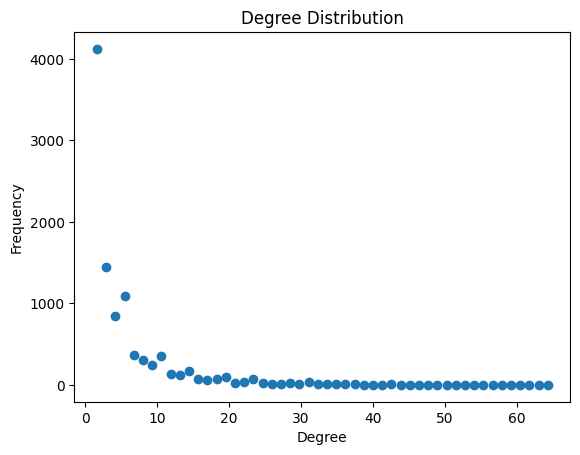

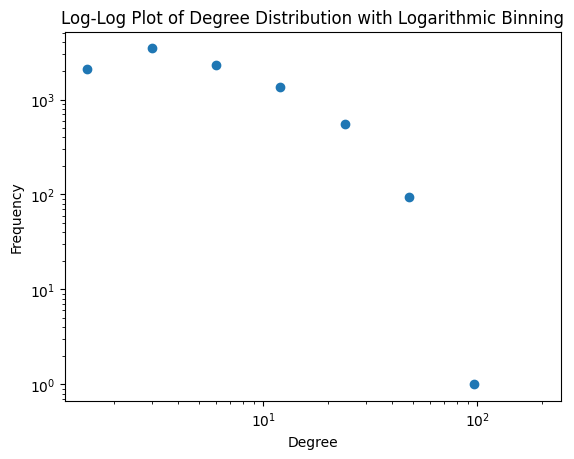

In [8]:
# load High Energy Physics collaboration network http://snap.stanford.edu/data/ca-HepTh.html
G = nx.read_edgelist('data/CA-HepTh.txt')

degrees = np.array([val for _,val in G.degree])

# ordinary plot
counts, edges = np.histogram(degrees, bins=50)
bin_centers = 0.5 * (edges[1:] + edges[:-1]) 
plt.plot(bin_centers, counts, 'o')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.show()

# logarithmic binning
bins = [min(degrees)]
for i in range(8):
    new_bin = bins[-1] + 2**(i)
    bins.append(new_bin)
bins = np.array(bins)
counts, edges = np.histogram(degrees, bins=bins)
bin_centers = 0.5 * (edges[1:] + edges[:-1]) 

# log-log plot
plt.plot(bin_centers, counts, 'o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Log-Log Plot of Degree Distribution with Logarithmic Binning')
plt.show()


In [9]:
fit = pwr.Fit(degrees, discrete=True, verbose=False)
R, p = fit.distribution_compare('power_law', 'lognormal', normalized_ratio=True)
print('Likelihood ratio of Powerlaw distribution with lognormal distribution', R, p)
R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print('Likelihood ratio of Powerlaw distribution with exponential distribution', R, p)
R, p = fit.distribution_compare('lognormal', 'exponential', normalized_ratio=True)
print('Likelihood ratio of lognormal distribution with exponential distribution', R, p)

Likelihood ratio of Powerlaw distribution with lognormal distribution -8.18502856911959 2.722390595553906e-16
Likelihood ratio of Powerlaw distribution with exponential distribution -5.214114626489527 1.8469723849313985e-07
Likelihood ratio of lognormal distribution with exponential distribution 0.873634819660882 0.3823171575751002


Comparing the powerlaw distribution fit with those of lognormal and exponential distribution reveals that both of them are a better fit than the powerlaw distribution, since the likelihood ratios are negative and the significance is way below any reasonable threshold. Comparing the two alternatives reveals that lognormal has a slight edge over exponential.

These results are also reflected in the plot below where we can see that the powerlaw distribution can't capture the steep drop in frequency of the very connected nodes (authors with many collaborations).

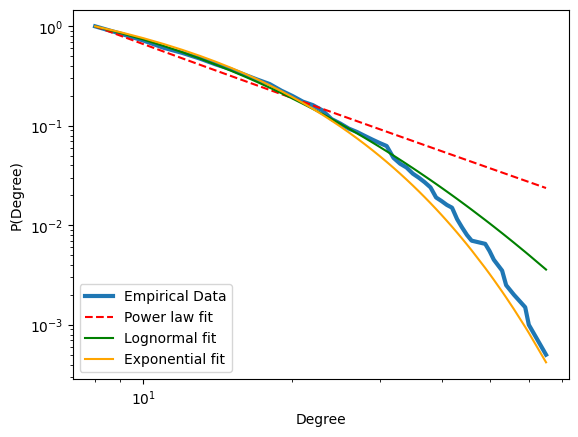

In [10]:
fig = fit.plot_ccdf(linewidth=3, label='Empirical Data')
fit.power_law.plot_ccdf(ax=fig, color='r', linestyle='--', label='Power law fit')
fit.lognormal.plot_ccdf(ax=fig, color='g', linestyle='-', label='Lognormal fit')
fit.exponential.plot_ccdf(ax=fig, color='orange', linestyle='-', label='Exponential fit')
####
fig.set_ylabel(u"P(Degree)")
fig.set_xlabel("Degree")
handles, labels = fig.get_legend_handles_labels()
fig.legend(handles, labels, loc=3)

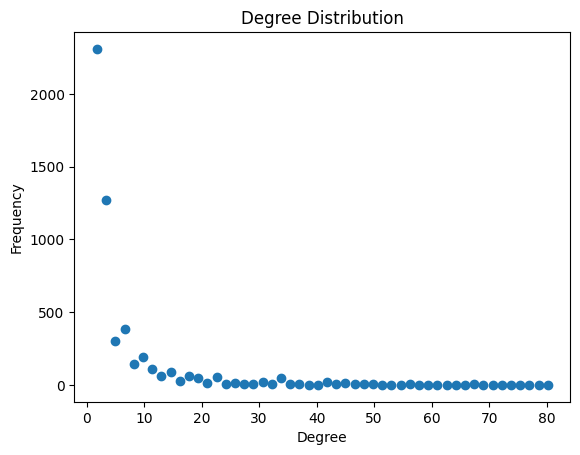

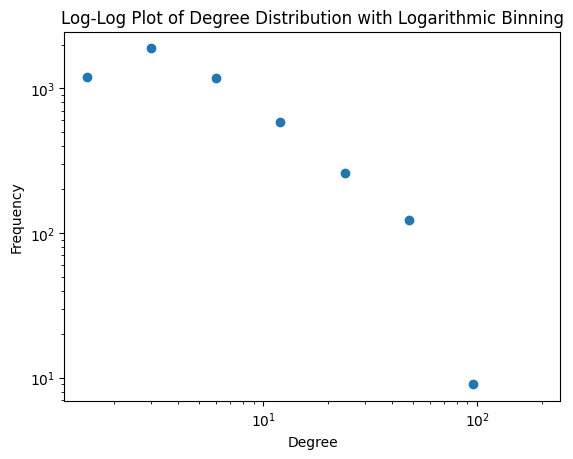

In [11]:
# load General Relativity and Quantum Cosmology collaboration network http://snap.stanford.edu/data/ca-GrQc.html
G = nx.read_edgelist('data/CA-GrQc.txt')

degrees = np.array([val for _,val in G.degree])

# ordinary plot
counts, edges = np.histogram(degrees, bins=50)
bin_centers = 0.5 * (edges[1:] + edges[:-1]) 
plt.plot(bin_centers, counts, 'o')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.show()

# logarithmic binning
bins = [min(degrees)]
for i in range(8):
    new_bin = bins[-1] + 2**(i)
    bins.append(new_bin)
bins = np.array(bins)
counts, edges = np.histogram(degrees, bins=bins)
bin_centers = 0.5 * (edges[1:] + edges[:-1]) 

# log-log plot
plt.plot(bin_centers, counts, 'o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Log-Log Plot of Degree Distribution with Logarithmic Binning')
plt.show()

In [12]:
fit = pwr.Fit(degrees, discrete=True, verbose=False)
R, p = fit.distribution_compare('power_law', 'lognormal', normalized_ratio=True)
print('Likelihood ratio of Powerlaw distribution with lognormal distribution', R, p)
R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print('Likelihood ratio of Powerlaw distribution with exponential distribution', R, p)

Likelihood ratio of Powerlaw distribution with lognormal distribution -8.264180401348941 1.4065776544471586e-16
Likelihood ratio of Powerlaw distribution with exponential distribution 7.329386814292145 2.312081536114696e-13


As the likelihood ratios reveal, the lognormal distribution is a better fit compared to the powerlaw distributiion, which in turn is a better fit than the exponential distribution though.

In the plot we can see that the powerlaw distribution again doesn't capture the steep drop of the very few very connected authors, while the exponential distribution overshoots this drop. The lognormal distribution can capture some of the drop but as it gets steeper it is also not able to fit those datapoints very well.

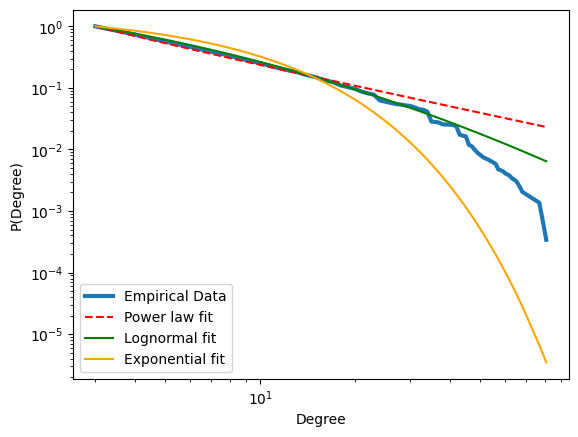

In [13]:
fig = fit.plot_ccdf(linewidth=3, label='Empirical Data')
fit.power_law.plot_ccdf(ax=fig, color='r', linestyle='--', label='Power law fit')
fit.lognormal.plot_ccdf(ax=fig, color='g', linestyle='-', label='Lognormal fit')
fit.exponential.plot_ccdf(ax=fig, color='orange', linestyle='-', label='Exponential fit')
fig.set_ylabel("P(Degree)")
fig.set_xlabel("Degree")
handles, labels = fig.get_legend_handles_labels()
fig.legend(handles, labels, loc=3)